Demo video (sarah): https://nyu.zoom.us/rec/play/Tmh2tXyYI5gGq9RnQLf91jz2fQQx0qRYRdGdZQVELOf-RLX6NyglwJlVJoYszU888jWCKxW6BuGXp9Qm.7-0Dp-ndE49milGy

In [ ]:
# This example has been adapted from Moritz Hardt's CS227 notes at UC Berkeley https://ee227c.github.io/

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Reinforcement Learning for Flappy Bird

Flappy bird is flying in the air at constant velocity. Its vertical position $h$ is governed by gravity and air resistance. The total downward force is $F = mg - kv,$ where $g$ is the acceleration due to gravity, $v$ is the downward velocity and $k$ is a drag coefficient that relates air resistance to velocity. Using $F=ma,$ this gives the first-order differential equation $\frac{dv}{dt}= g - \frac{k}{m}v.$

Flappy can choose to accelerate upwards. We need to learn a policy of accelerating upwards so that Flappy doesn't crash into the ground ($h=0$).

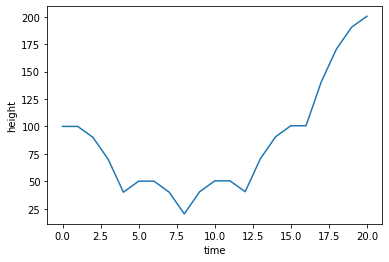

In [ ]:
def flappy_bird(state, action):
    """
    state: [downward velocity, height]
    action: acceleration (upward)
    """
    v, h = state
    g = 10. # acceleration due to gravity
    k = 0.01 # drag coefficient
    m = 10. # mass
    return (v + g - (k/m)*v - action, h - v)

def simulate(system, inits, policy, horizon):
    """
    Integrate the dynamical system for a given horizon using a given 
    initial condition and policy
    Returns: sequence of states, sequence of actions
    """
    states = [inits[0]]
    actions = [inits[1]]
    for _ in range(horizon):
        action = policy(states, actions)
        actions.append(action)
        states.append(system(states[-1], action))
    return states, actions

def test_policy(states, actions):
    """
    Returns: upwards acceleration of 50 every 4 steps
    """
    v, h = states[-1]
    if divmod(len(states), 4)[1] == 0:
        return 50
    else:
        return 0.

flappy_inits = [(0, 100.), 0]
states, actions = simulate(flappy_bird, flappy_inits, test_policy, horizon=20)
heights = [h for (v, h) in states]

fig, ax = plt.subplots()
ax.set_ylabel('height'); 
ax.set_xlabel('time');
ax.plot(range(len(heights)), heights);
fig.show()

Note that this policy is good (Flappy never crashes) but we had to guess it. Try playing around with other policies.

# Random Search
Policy gradients in RL is similar to gradient-free optimization (or random search). Let's implement that first:

In [ ]:
def ts(f, a, b, epsilon=1e-3):
    while abs(b - a) > epsilon: # while window size > tolerance
        c = a + (b - a) / 3
        d = b - (b - a) / 3
        if f(c) < f(d): # if f(lower) < f(upper)
            b = d # update end of window to decremented upper bound
        else: # f(upper) < f(lower)
            a = c # update start of window to incremented lower bound
            # i.e. move window towards lower value of the curve: descent along curve

    return (a + b) / 2 # return average of bounds
 
def random_search(objective, init, num_steps, line_search=ts, seed=1):
    """
    Samples a random direction d to update theta using line search to find 
    the (scalar) step size that provides maximum decrease in the objective function
    along that direction

    Arguments:
    objective: function to be optimized
    init: initial value of parameter vector theta
    num_steps: number of optimization steps
    line_search: line search implementation
    Returns: the series of values of the parameter vector over the course of 
             num_steps optimization steps
    """
    np.random.seed(seed)
    iterates = [init]
    for _ in range(num_steps):
        # 1. Sample a random direction d:
        # generate uniformly distributed random points on the unit (n − 1)-sphere
        # (surface of the unit n-ball):
        # a. generate a random n-dimensional vector of normal deviates
        d = np.random.normal(0, 100, init.shape)
        # b. calculate the "radius" of this point
        r = np.linalg.norm(d)
        # c. the vector (1/r)x is uniformly distributed over the surface of the unit n-ball
        d = d / r
        
        # 2. Use line search for a step size eta that minimizes f(theta + eta * d)
        theta = iterates[-1]
        f = lambda eta: objective(theta + eta * d)
        eta_opt = line_search(f, -1, 1)
        
        # 3. Set theta = theta + eta_opt * d
        iterates.append(theta + eta_opt * d)

    return iterates

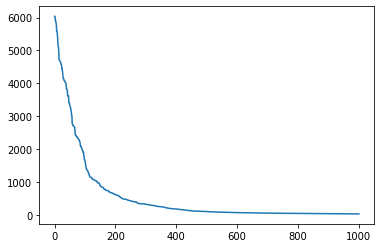

In [ ]:
# example: objective = least squares
A = np.random.normal(0, 1, (100, 100))
b = np.random.normal(0, 1, (100,))
def least_squares(x):
    return 0.5 * np.linalg.norm(A.dot(x) - b)**2

xs = random_search(least_squares, b, 1000, ts)
fig, ax = plt.subplots()
ax.plot([least_squares(x) for x in xs])
fig.show()

OK, now let's use RL to *learn* a policy of (upward) accelerations for Flappy. This, as we discussed in class, is going to be done using gradient-free optimization. We would like to minimize the number of upward "boosts" needed without ever crashing to the ground.

In RL, we need to set up:
* a *reward*
* a parametric *policy*
* a *simulator* that returns a reward for a rollout using a given policy
* an *objective function* that captures the effect of the policy on the reward for a given trajectory
* and the optimization algorithm that is used.

In [ ]:
def flappy_policy(param, states, actions):
    """
    Policy is a linear map of last two states, ignoring previous actions.
    Returns: action (scalar acceleration)
    """
    if len(states) == 1: # if there is only one state so far
        states = states + states # double so states.size >= 2
    return np.dot(param, np.reshape(np.array(states[-2:]), (4,)))

In [ ]:
def flappy_reward(states, actions):
    """
    Penalize crashing a lot, penalize large acceleration a bit
    Returns: scalar reward
    """
    reward = 0
    for state, action in zip(states, actions):
        _, height = state
        if height < 0:
            reward += 10 * height # if flappy crashes
        reward -= action # if we accelerate, we burn fuel
    return reward

def flappy_simulator(param, num_steps):
    policy = lambda states, actions: flappy_policy(param, states, actions)
    states, actions = simulate(flappy_bird, flappy_inits, policy, num_steps)
    return flappy_reward(states, actions)

def objective(param, horizon=20):
  return -1 * flappy_simulator(param, horizon)

In [ ]:
def plot_trajectory(trajectories): 
    fig, ax = plt.subplots()
    for states in trajectories:
        heights = [h for (v, h) in states]
        fig = plt.figure(figsize=(8, 8))
        ax.set_ylabel('height'); 
        ax.set_xlabel('time');
        #ax.set_ylim(0, 120.)
        ax.plot(range(len(heights)), heights);
    fig.show()

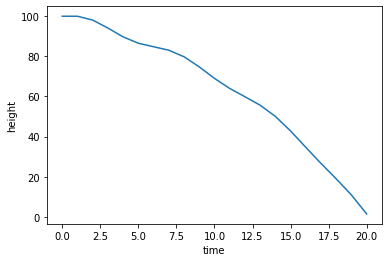

<Figure size 576x576 with 0 Axes>

In [ ]:
# Use random search to optimize the policy
optimal_param = random_search(objective, np.zeros(4), num_steps=20, line_search=ts) # 20 optimization steps
# Use last iteration of parameter optimization series
rl_policy = lambda states, actions: flappy_policy(optimal_param[-1], states, actions)

# Test the policy
states, actions = simulate(flappy_bird, flappy_inits, rl_policy, 20)
plot_trajectory([states])

Cool! Looks like we learned a reasonably successful policy. In this trajectory, Flappy avoids ever hitting the ground on the horizon it was trained for, while minimizing the amount of upward acceleration necessary.

Unfortunately since we have used sample rollouts instead of calculating the actual expectation over the rewards, our final model is rather unstable. We can see that different choices of seed for the random number generator result in unstable trajectories:

seeds: [27 19  7 42 18 10 43 34 32 17]


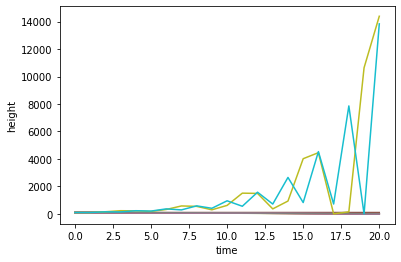

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [ ]:
trajectories = []
rng = np.random.default_rng()
seeds = rng.integers(1, high=50, size=10)
print("seeds:", seeds)

def objective(param, horizon=20):
        return -1 * flappy_simulator(param, horizon)

for seed in seeds:
    optimal_param = random_search(objective, np.zeros(4), num_steps=20, line_search=ts, seed=seed)
    rl_policy = lambda states, actions: flappy_policy(optimal_param[-1], states, actions)

    states, actions = simulate(flappy_bird, flappy_inits, rl_policy, 20)
    trajectories.append(states)

plot_trajectory(trajectories)

Also, we have used a fixed number of 20 time steps for each sample rollout. This has a dramatic effect on the learned policy as well. We can see that for horizon lengths above about 40 time steps, Flappy is unable to learn a policy that results in a stable trajectory for the entire horizon:

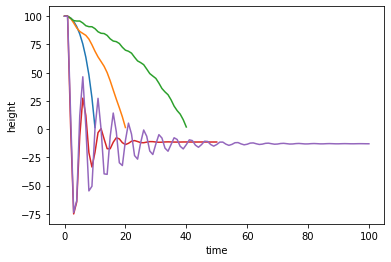

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [ ]:
trajectories = []
for horizon in [10, 20, 40, 50, 100]:
    def objective(param, horizon=horizon):
        return -1 * flappy_simulator(param, horizon)

    optimal_param = random_search(objective, np.zeros(4), num_steps=20, line_search=ts)
    rl_policy = lambda states, actions: flappy_policy(optimal_param[-1], states, actions)

    states, actions = simulate(flappy_bird, flappy_inits, rl_policy, horizon)
    trajectories.append(states)
plot_trajectory(trajectories)